# Model Comparison (hourly data)

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [2]:
# Check for GPU
import tensorflow as tf
try:
    from google.colab import drive
    IN_COLAB=True
except:
    IN_COLAB=False

if IN_COLAB:
    print("We're running Colab")
else:
    print(tf.config.list_physical_devices())
    print('\nCUDA GPU: ' + str(tf.test.is_gpu_available(cuda_only=True)))

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.

CUDA GPU: True


In [3]:
import pickle
from sklearn.model_selection import train_test_split

with open('./LSTM/cleaned_data.pkl', 'rb') as f:
    data = pickle.load(f)
    
train, test = train_test_split(data, test_size=0.2, shuffle = False)

In [4]:
from sklearn.preprocessing import MinMaxScaler
import pickle

with open('./LSTM/models/hourly_scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

train = scaler.transform(train)
test = scaler.transform(test)

In [5]:
# load model
modelpath_list = ['./LSTM/models/LSTM_16-4', './LSTM/models/LSTM_24-6', 
                 './LSTM/models/LSTM_32-8', './LSTM/models/LSTM_40-10',
                 './LSTM/models/BiLSTM_16-4', './LSTM/models/BiLSTM_24-6', 
                 './LSTM/models/BiLSTM_32-8', './LSTM/models/BiLSTM_40-10',
                 './LSTM/models/LSTM-FC_16-4', './LSTM/models/LSTM-FC_24-6', 
                 './LSTM/models/LSTM-FC_32-8', './LSTM/models/LSTM-FC_40-10',
                 './LSTM/models/BiLSTM-FC_16-4', './LSTM/models/BiLSTM-FC_24-6', 
                 './LSTM/models/BiLSTM-FC_32-8', './LSTM/models/BiLSTM-FC_40-10']

predictions = dict()

In [6]:
# start date for predictions
start_date = data.index[len(train) + 40]
start_index = len(data.loc[:start_date,:])
    
for path in modelpath_list:
    model = tf.keras.models.load_model(path)
    in_out = path.split('_')[-1]
    input_len = int(in_out.split('-')[0])
    output_len = int(in_out.split('-')[1])
    # train period
    input_X = test[40 - input_len : 40, :-1]
    
    pred = scaler.data_range_[-1] * model.predict([input_X])[0] + scaler.data_min_[-1]
    predictions[model.name] = pred

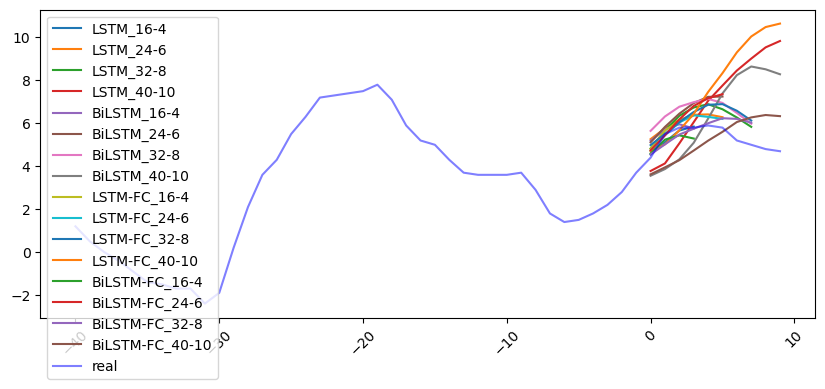

In [7]:
step = 40
real_output = scaler.data_range_[-1] * test[40 - step:50, -1] + scaler.data_min_[-1]
plt.figure(figsize=(10,4))
for key, pred in predictions.items():
    plt.plot(np.arange(0, len(pred)), pred, label = key)
plt.plot(np.arange(-step, 10),real_output, label = 'real', color = 'blue', alpha = 0.5)
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [8]:
# splitting data into sequences
def split_sequences(features, target, seq_len, forecast_len):
    X,y = list(), list()
    for i in range(len(features)):
        end_input = i + seq_len
        end_predict = end_input + forecast_len
        if end_predict > len(features)-1:
            break
        seq_x, seq_y = features[i:end_input,:], target[end_input:end_predict]
        X.append(seq_x)
        y.append(seq_y)
    return tf.convert_to_tensor(X, dtype=tf.float64), tf.convert_to_tensor(y, dtype=tf.float64)

In [9]:
from sklearn.metrics import mean_squared_error

mse_all = dict()
rmse_all = dict()
predictions = dict()
mse = dict()
rmse = dict()
actual = dict()

for path in modelpath_list:
    model = tf.keras.models.load_model(path)
    in_out = path.split('_')[-1]
    input_len = int(in_out.split('-')[0])
    output_len = int(in_out.split('-')[1])
    
    X_train, y_train = split_sequences(train[:,:-1], train[:,-1], seq_len =  input_len, forecast_len = output_len)
    X_test, y_test = split_sequences(test[:,:-1], test[:,-1],seq_len = input_len, forecast_len =  output_len)
    n_features = X_train.shape[2]
    
    y_hat_test = scaler.data_range_[-1] * model.predict(X_test) + scaler.data_min_[-1] 
    y_test = scaler.data_range_[-1] * y_test + scaler.data_min_[-1] 
    
    y_hat_train = scaler.data_range_[-1] * model.predict(X_train) + scaler.data_min_[-1] 
    y_train = scaler.data_range_[-1] * y_train + scaler.data_min_[-1] 
    
    mse_all[model.name] = [mean_squared_error(y_train, y_hat_train) , mean_squared_error(y_test, y_hat_test)]
    rmse_all[model.name] = np.sqrt(mse_all[model.name])
    predictions[model.name] = [y_hat_train, y_hat_test]
    actual[model.name] = [y_train, y_test]
    
    mse[model.name] = []
    rmse[model.name] = []
    for i in range(output_len):
        mse[model.name].append(mean_squared_error(y_test[:,i], y_hat_test[:,i]))
        rmse[model.name].append(mean_squared_error(y_test[:,i], y_hat_test[:,i], squared = False))

In [10]:
with open('./mse_all.pkl', 'wb') as f:
    pickle.dump(mse_all, f)
with open('./rmse_all.pkl', 'wb') as f:
    pickle.dump(rmse_all, f)
with open('./predictions.pkl', 'wb') as f:
    pickle.dump(predictions, f)
with open('./actual.pkl', 'wb') as f:
    pickle.dump(actual, f)
    
with open('./mse.pkl', 'wb') as f:
    pickle.dump(mse, f)
with open('./rmse.pkl', 'wb') as f:
    pickle.dump(rmse, f)

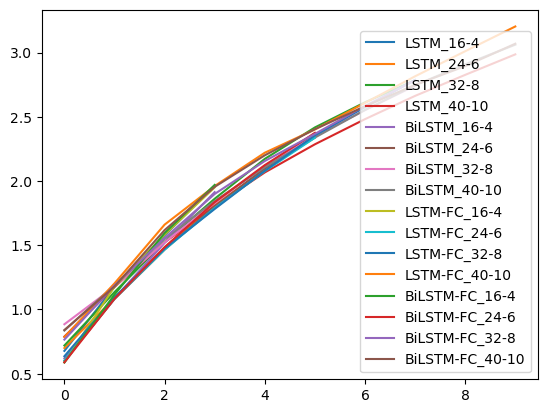

In [11]:
for key, item in rmse.items():
    plt.plot(item, label = key)
plt.legend()
plt.show()

In [12]:
mse_all

{'LSTM_16-4': [1.8304440681406144, 2.045259371403369],
 'LSTM_24-6': [2.5559367954390435, 2.833997072117881],
 'LSTM_32-8': [3.6297562436859954, 4.092491932594907],
 'LSTM_40-10': [4.326433320315774, 4.722403151524274],
 'BiLSTM_16-4': [1.6976998699494816, 1.8822206732665268],
 'BiLSTM_24-6': [2.447197414811305, 2.826721908510338],
 'BiLSTM_32-8': [3.5186435598776837, 3.9839487875280195],
 'BiLSTM_40-10': [4.42205090785344, 4.97112718217613],
 'LSTM-FC_16-4': [1.8360869614599022, 2.0106498533540216],
 'LSTM-FC_24-6': [2.446576965488441, 2.7779448592671887],
 'LSTM-FC_32-8': [3.486195644458234, 3.902809235080084],
 'LSTM-FC_40-10': [4.666956123876718, 5.340452499137529],
 'BiLSTM-FC_16-4': [1.8283678609734062, 2.003455354453857],
 'BiLSTM-FC_24-6': [2.4629278074029464, 2.8733750174269796],
 'BiLSTM-FC_32-8': [3.438300935492914, 4.087145446688269],
 'BiLSTM-FC_40-10': [4.516943754604353, 5.115871769042711]}

In [13]:
rmse_all

{'LSTM_16-4': array([1.35293905, 1.43012565]),
 'LSTM_24-6': array([1.59872974, 1.68344797]),
 'LSTM_32-8': array([1.90519192, 2.02299084]),
 'LSTM_40-10': array([2.08000801, 2.1731091 ]),
 'BiLSTM_16-4': array([1.30295812, 1.37194048]),
 'BiLSTM_24-6': array([1.56435208, 1.68128579]),
 'BiLSTM_32-8': array([1.87580478, 1.99598316]),
 'BiLSTM_40-10': array([2.10286731, 2.22960247]),
 'LSTM-FC_16-4': array([1.35502286, 1.41797385]),
 'LSTM-FC_24-6': array([1.56415375, 1.66671679]),
 'LSTM-FC_32-8': array([1.86713568, 1.97555289]),
 'LSTM-FC_40-10': array([2.16031389, 2.31094191]),
 'BiLSTM-FC_16-4': array([1.35217154, 1.41543469]),
 'BiLSTM-FC_24-6': array([1.56937179, 1.69510325]),
 'BiLSTM-FC_32-8': array([1.85426561, 2.02166898]),
 'BiLSTM-FC_40-10': array([2.12531027, 2.2618293 ])}

In [14]:
rmse_df = pd.DataFrame(rmse_all).T

In [15]:
rmse_df.columns = ['Train', 'Test']

In [16]:
rmse_df

Train      Test
LSTM_16-4        1.352939  1.430126
LSTM_24-6        1.598730  1.683448
LSTM_32-8        1.905192  2.022991
LSTM_40-10       2.080008  2.173109
BiLSTM_16-4      1.302958  1.371940
BiLSTM_24-6      1.564352  1.681286
BiLSTM_32-8      1.875805  1.995983
BiLSTM_40-10     2.102867  2.229602
LSTM-FC_16-4     1.355023  1.417974
LSTM-FC_24-6     1.564154  1.666717
LSTM-FC_32-8     1.867136  1.975553
LSTM-FC_40-10    2.160314  2.310942
BiLSTM-FC_16-4   1.352172  1.415435
BiLSTM-FC_24-6   1.569372  1.695103
BiLSTM-FC_32-8   1.854266  2.021669
BiLSTM-FC_40-10  2.125310  2.261829

In [17]:
print(rmse_df.to_latex(index=True,  float_format="{:.4f}".format))

\begin{tabular}{lrr}
\toprule
{} &  Train &   Test \\
\midrule
LSTM\_16-4       & 1.3529 & 1.4301 \\
LSTM\_24-6       & 1.5987 & 1.6834 \\
LSTM\_32-8       & 1.9052 & 2.0230 \\
LSTM\_40-10      & 2.0800 & 2.1731 \\
BiLSTM\_16-4     & 1.3030 & 1.3719 \\
BiLSTM\_24-6     & 1.5644 & 1.6813 \\
BiLSTM\_32-8     & 1.8758 & 1.9960 \\
BiLSTM\_40-10    & 2.1029 & 2.2296 \\
LSTM-FC\_16-4    & 1.3550 & 1.4180 \\
LSTM-FC\_24-6    & 1.5642 & 1.6667 \\
LSTM-FC\_32-8    & 1.8671 & 1.9756 \\
LSTM-FC\_40-10   & 2.1603 & 2.3109 \\
BiLSTM-FC\_16-4  & 1.3522 & 1.4154 \\
BiLSTM-FC\_24-6  & 1.5694 & 1.6951 \\
BiLSTM-FC\_32-8  & 1.8543 & 2.0217 \\
BiLSTM-FC\_40-10 & 2.1253 & 2.2618 \\
\bottomrule
\end{tabular}



In [18]:
predictions

{'LSTM_16-4': [array([[3.0959587, 3.329319 , 3.7047958, 3.8533363],
         [2.6209126, 3.0990257, 3.724884 , 4.0716057],
         [3.032627 , 3.5981407, 4.349922 , 4.829853 ],
         ...,
         [7.0102005, 7.32856  , 7.578579 , 7.329895 ],
         [6.623356 , 6.4986153, 6.3240395, 5.7428703],
         [5.5814323, 5.138523 , 4.5328026, 3.4697113]], dtype=float32),
  array([[ 6.2470207 ,  6.8883324 ,  7.45459   ,  7.4564133 ],
         [ 7.4987946 ,  8.12711   ,  8.618698  ,  8.513218  ],
         [ 7.306217  ,  7.7197266 ,  8.0673485 ,  7.8675003 ],
         ...,
         [ 5.922348  ,  4.786606  ,  3.9763412 ,  3.1785164 ],
         [ 3.3711662 ,  1.9905281 ,  1.1958828 ,  0.49045944],
         [ 1.3763733 ,  0.25603485, -0.39503098, -0.9744091 ]],
        dtype=float32)],
 'LSTM_24-6': [array([[ 8.178326 ,  8.20182  ,  8.357765 ,  8.346783 ,  8.187656 ,
           8.002468 ],
         [ 9.254398 ,  9.202881 ,  9.297924 ,  9.2135315,  9.021698 ,
           8.896568 ],
         

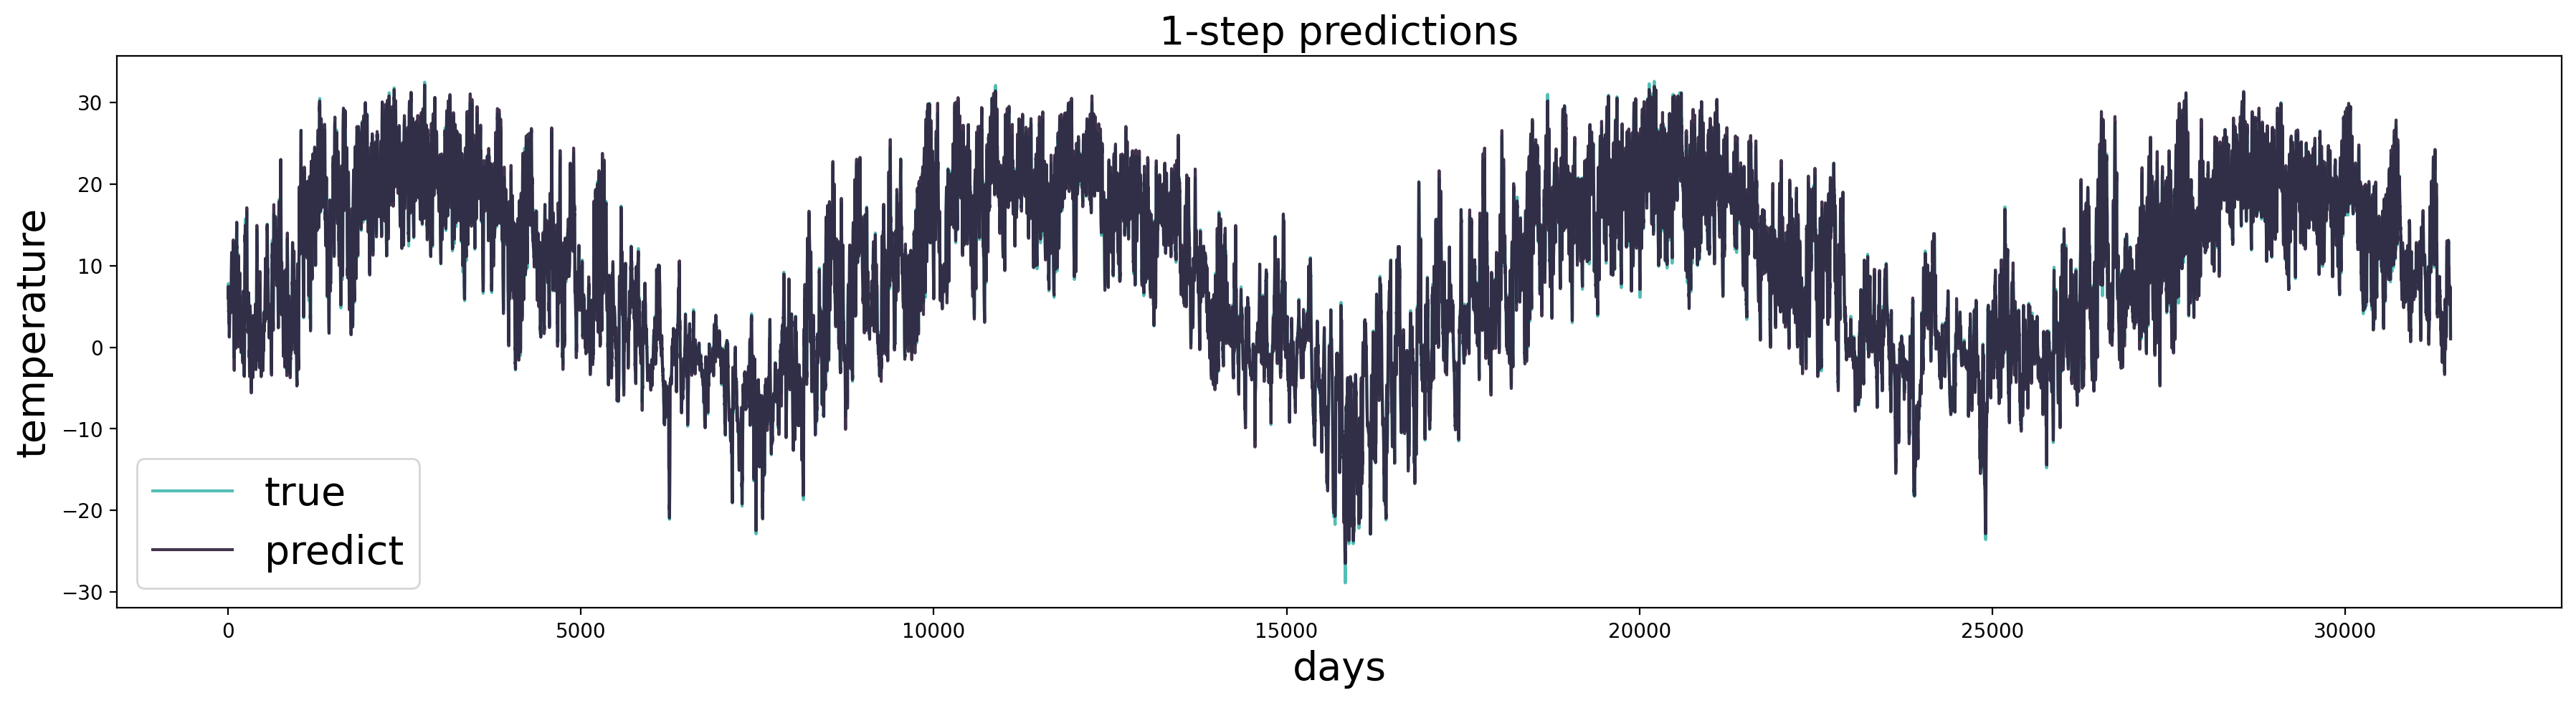

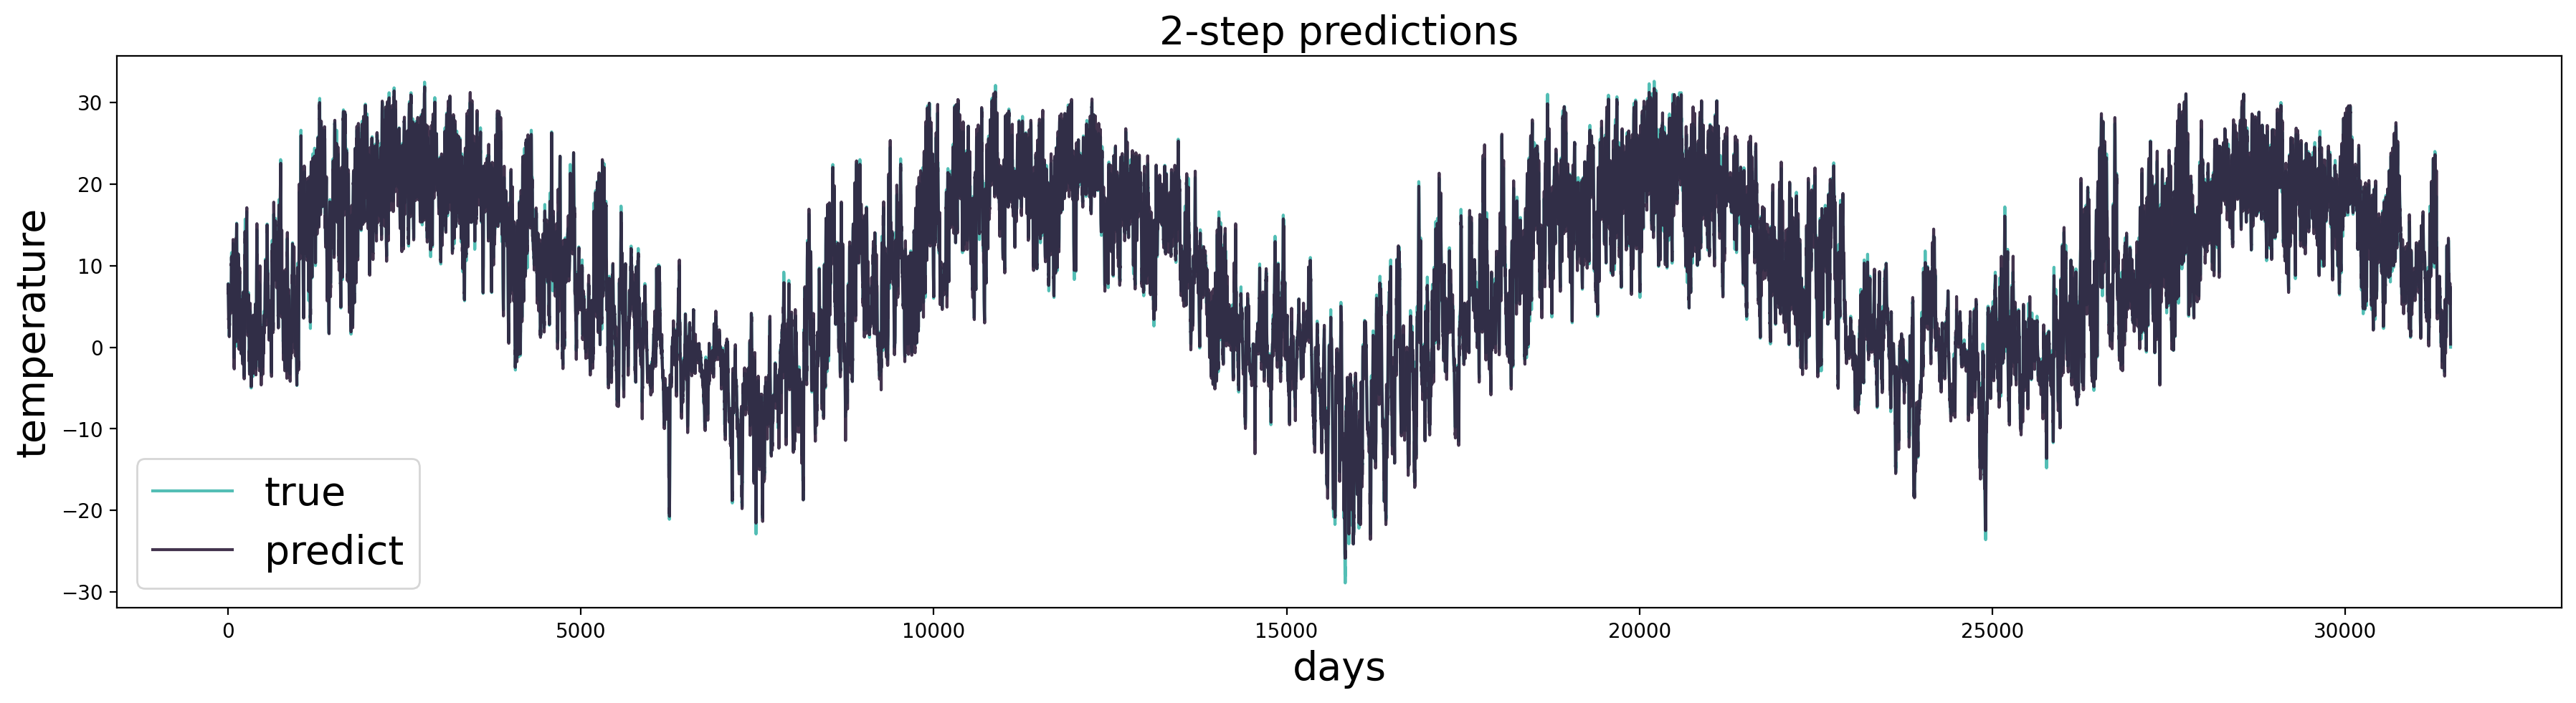

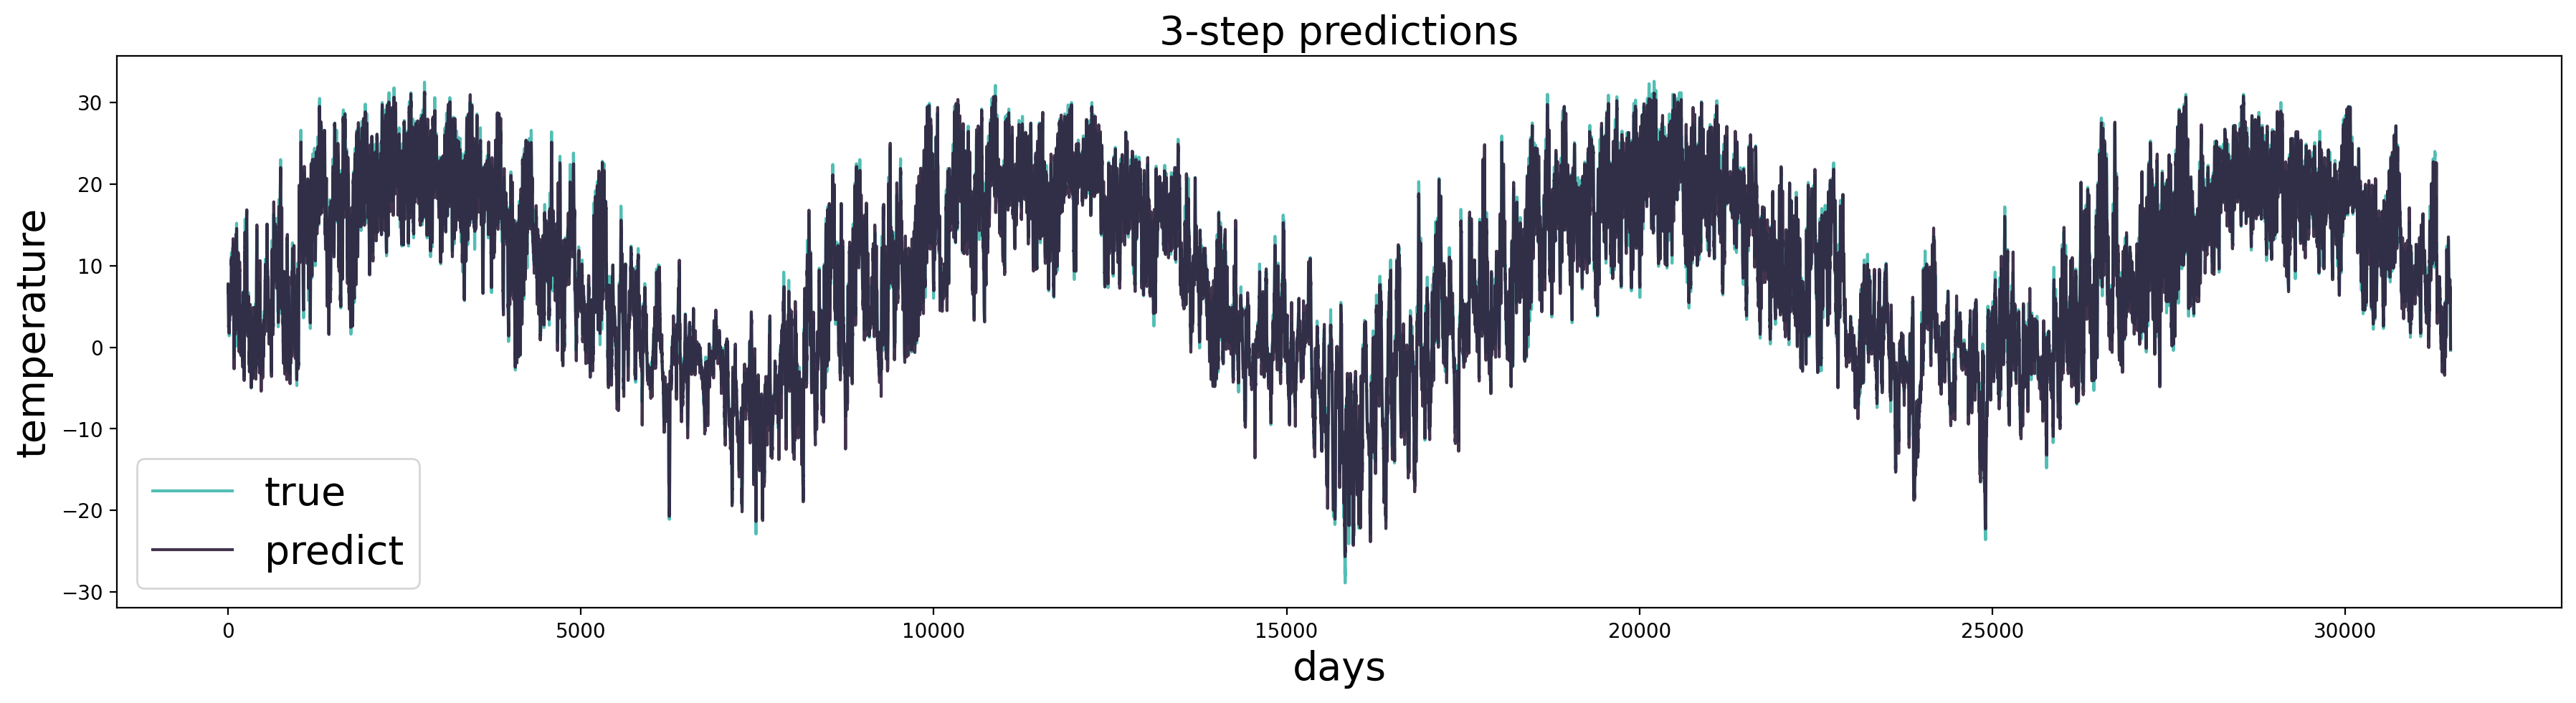

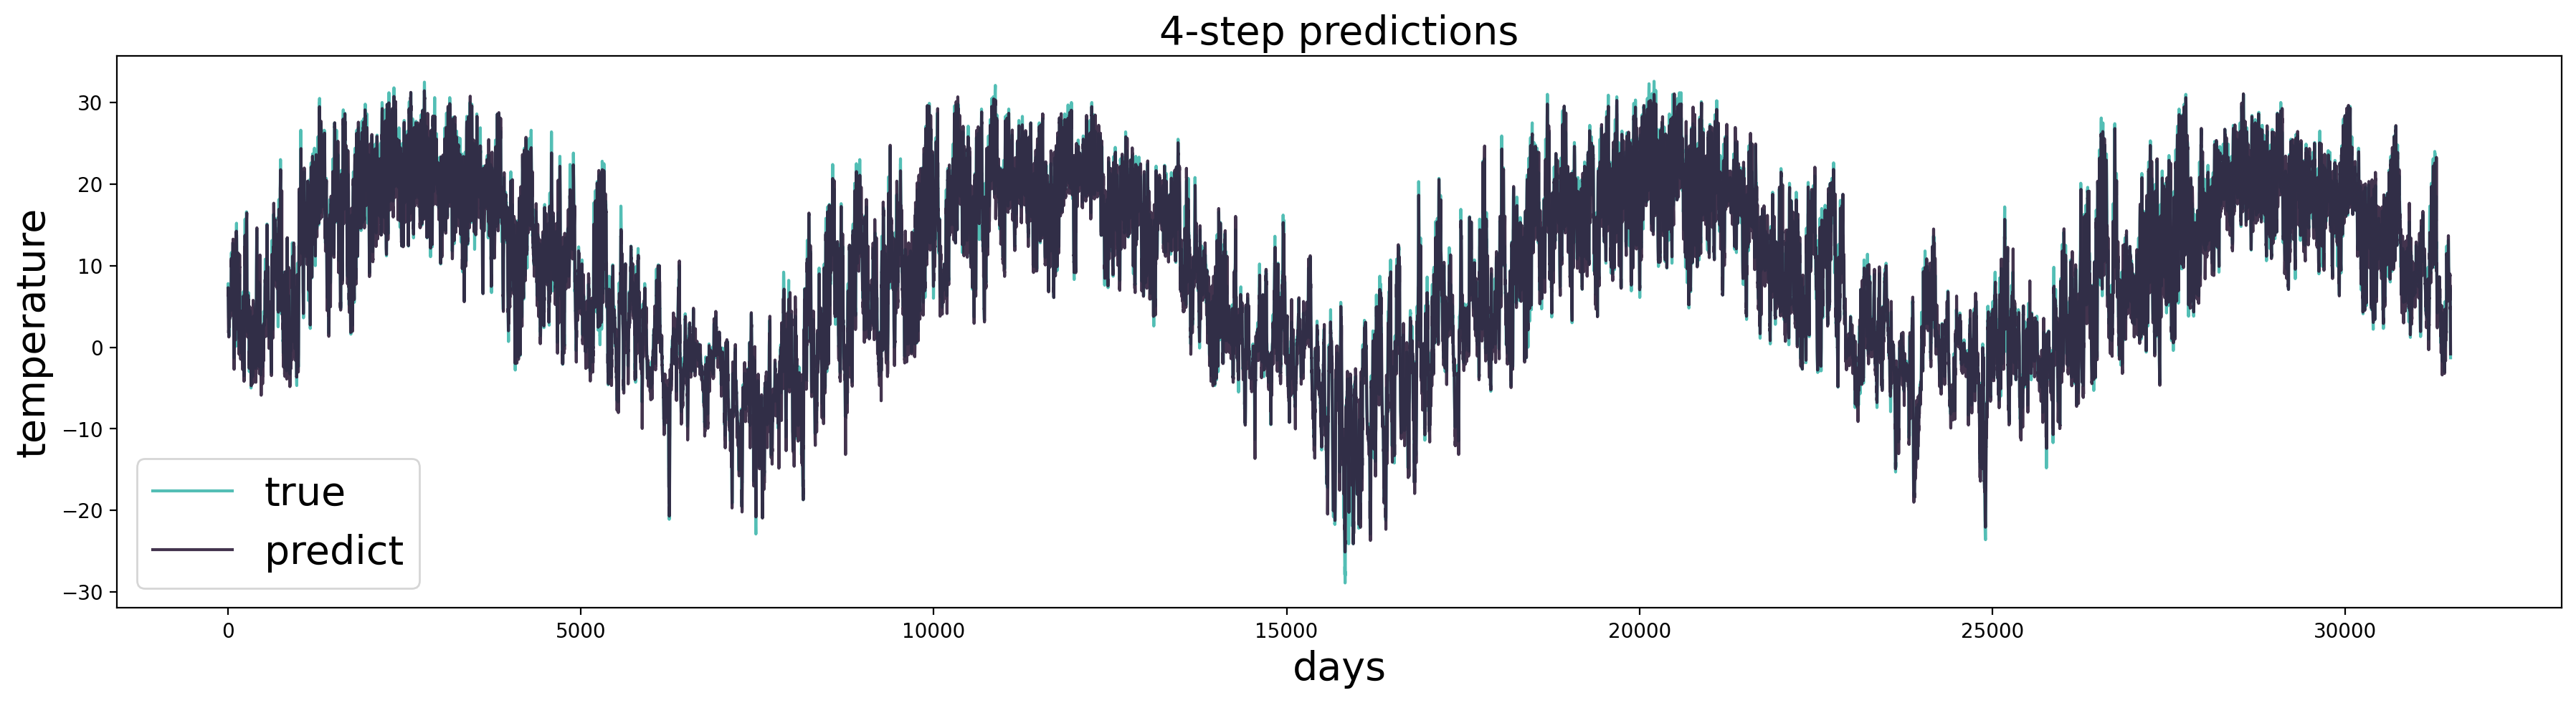

In [19]:
def plot_forecast(true, pred, title):
    fig, ax = plt.subplots(1, 1, figsize=(22, 5), dpi=200)
    fontsize = 20
    labelsize = 12
    colors = ['#7fcdbb', '#2c7fb8']
    palette = sns.color_palette("mako_r", 6)
    ax.plot(true, label = 'true', color = palette[1], alpha = 0.9)
    ax.plot(pred, label = 'predict', color = palette[-1], alpha = 0.9)
    plt.legend(fontsize=fontsize)
    plt.xlabel('days', fontsize=fontsize)
    plt.ylabel('temperature', fontsize=fontsize)
    plt.title(title, fontsize=fontsize)
    plt.show()

for i in range(4):
    plot_forecast(actual['BiLSTM-FC_16-4'][1][:,i], predictions['BiLSTM-FC_16-4'][1][:,i], title = str(i+1) + '-step predictions')

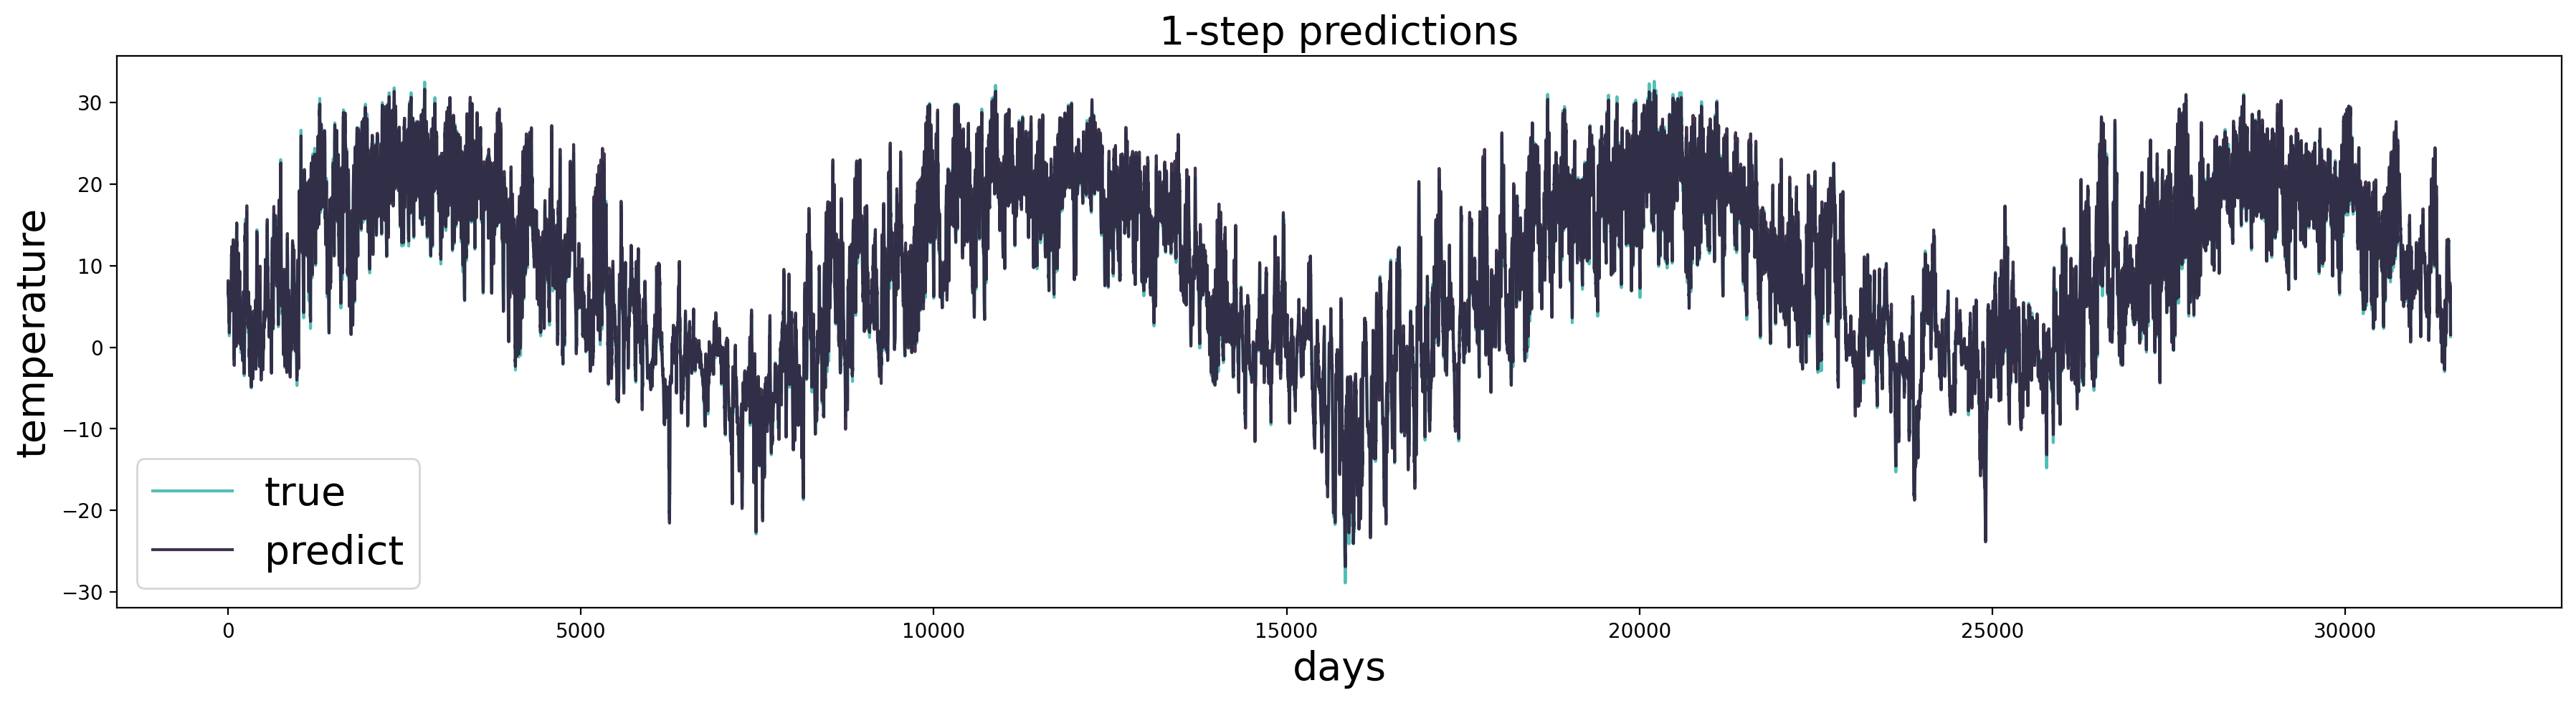

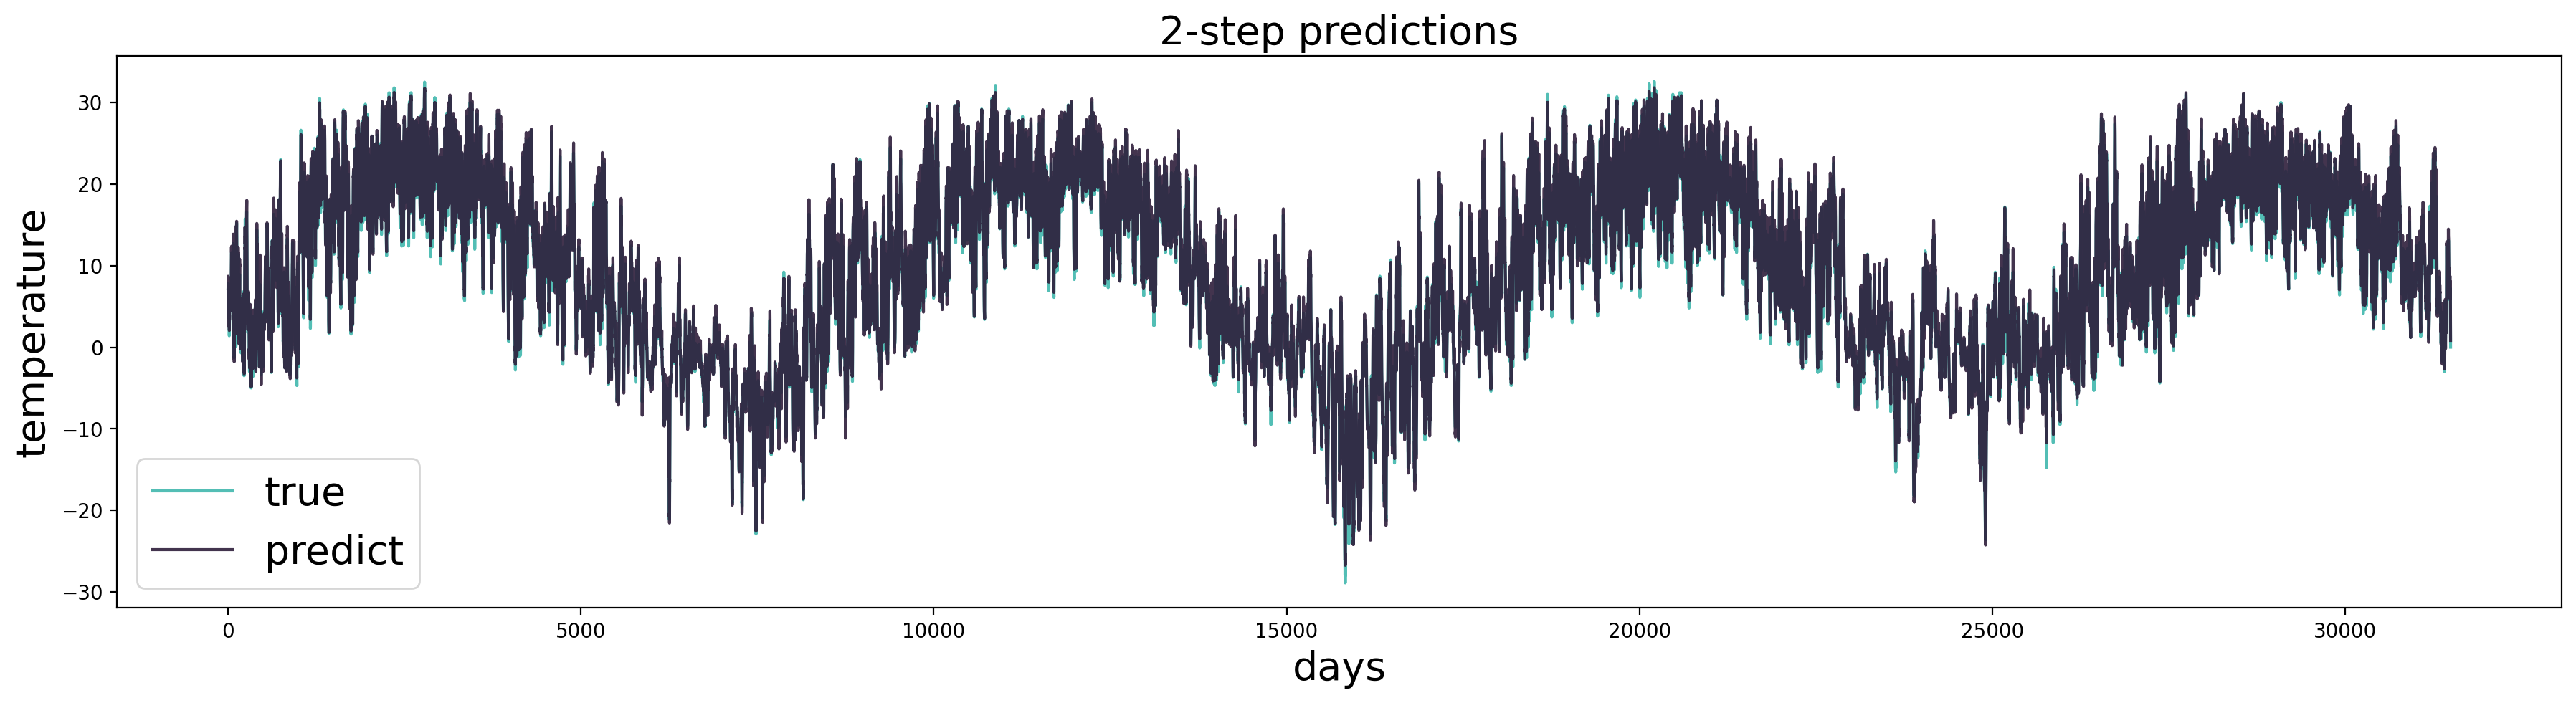

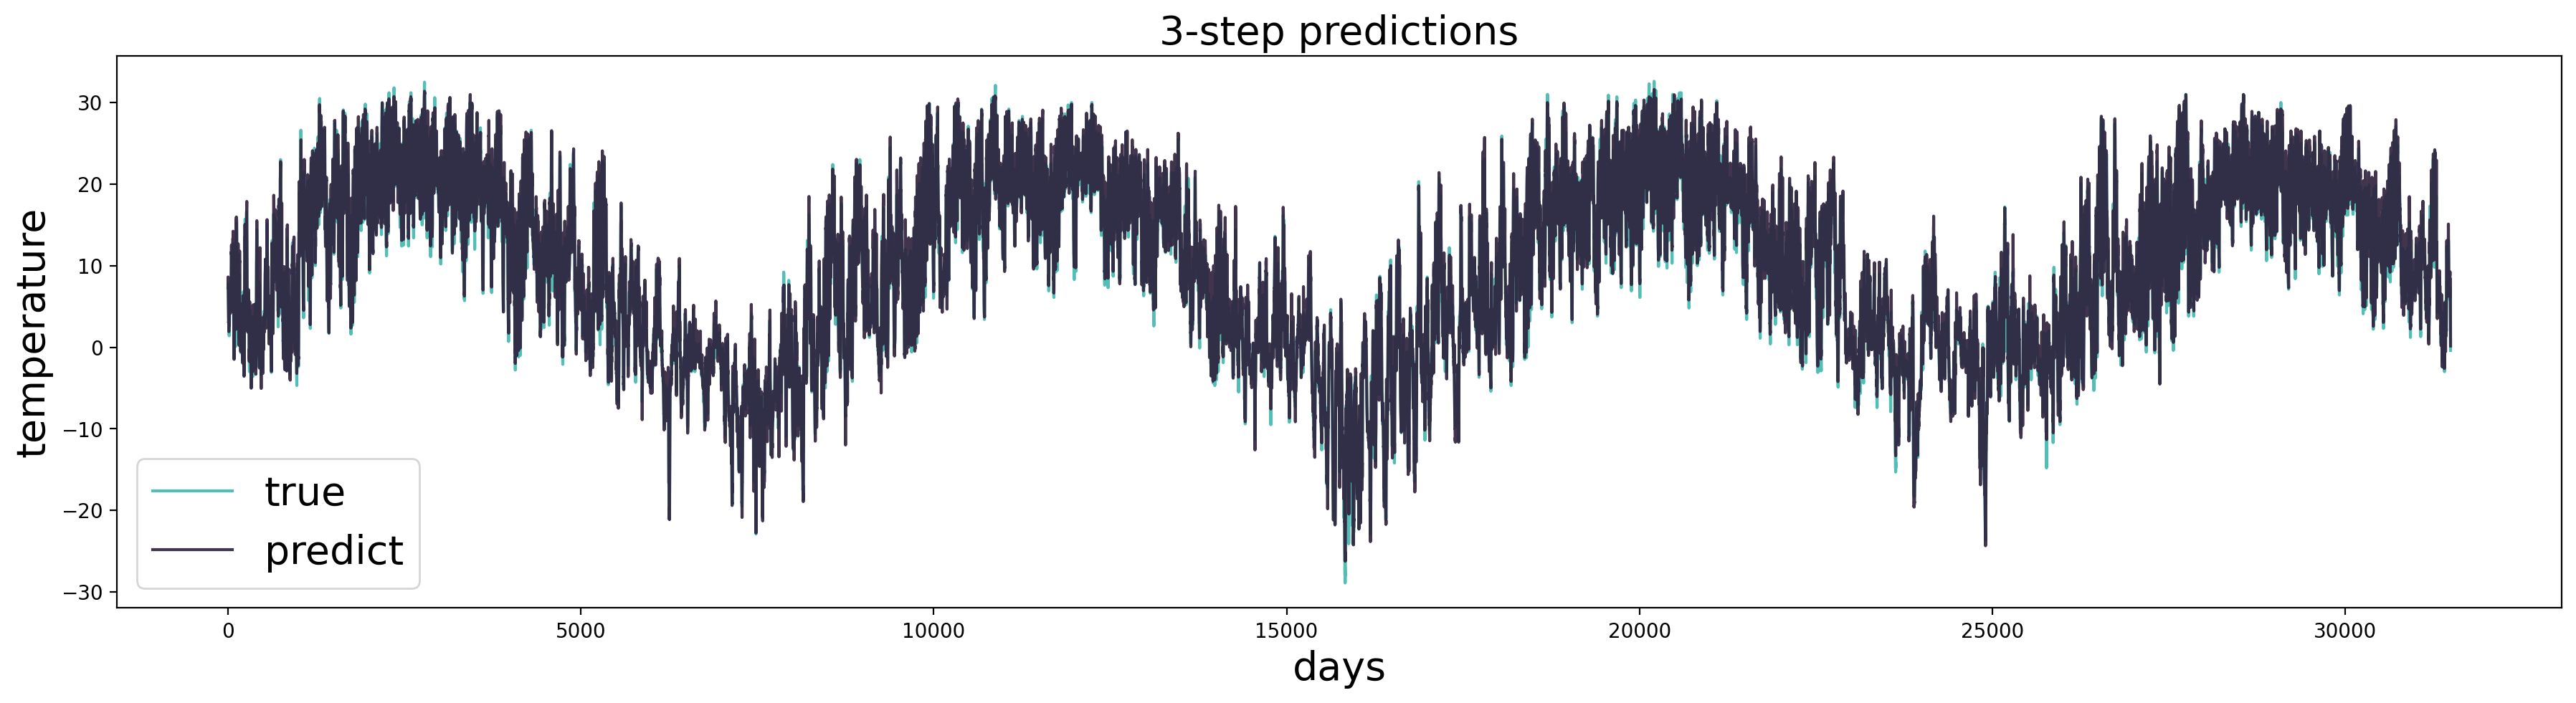

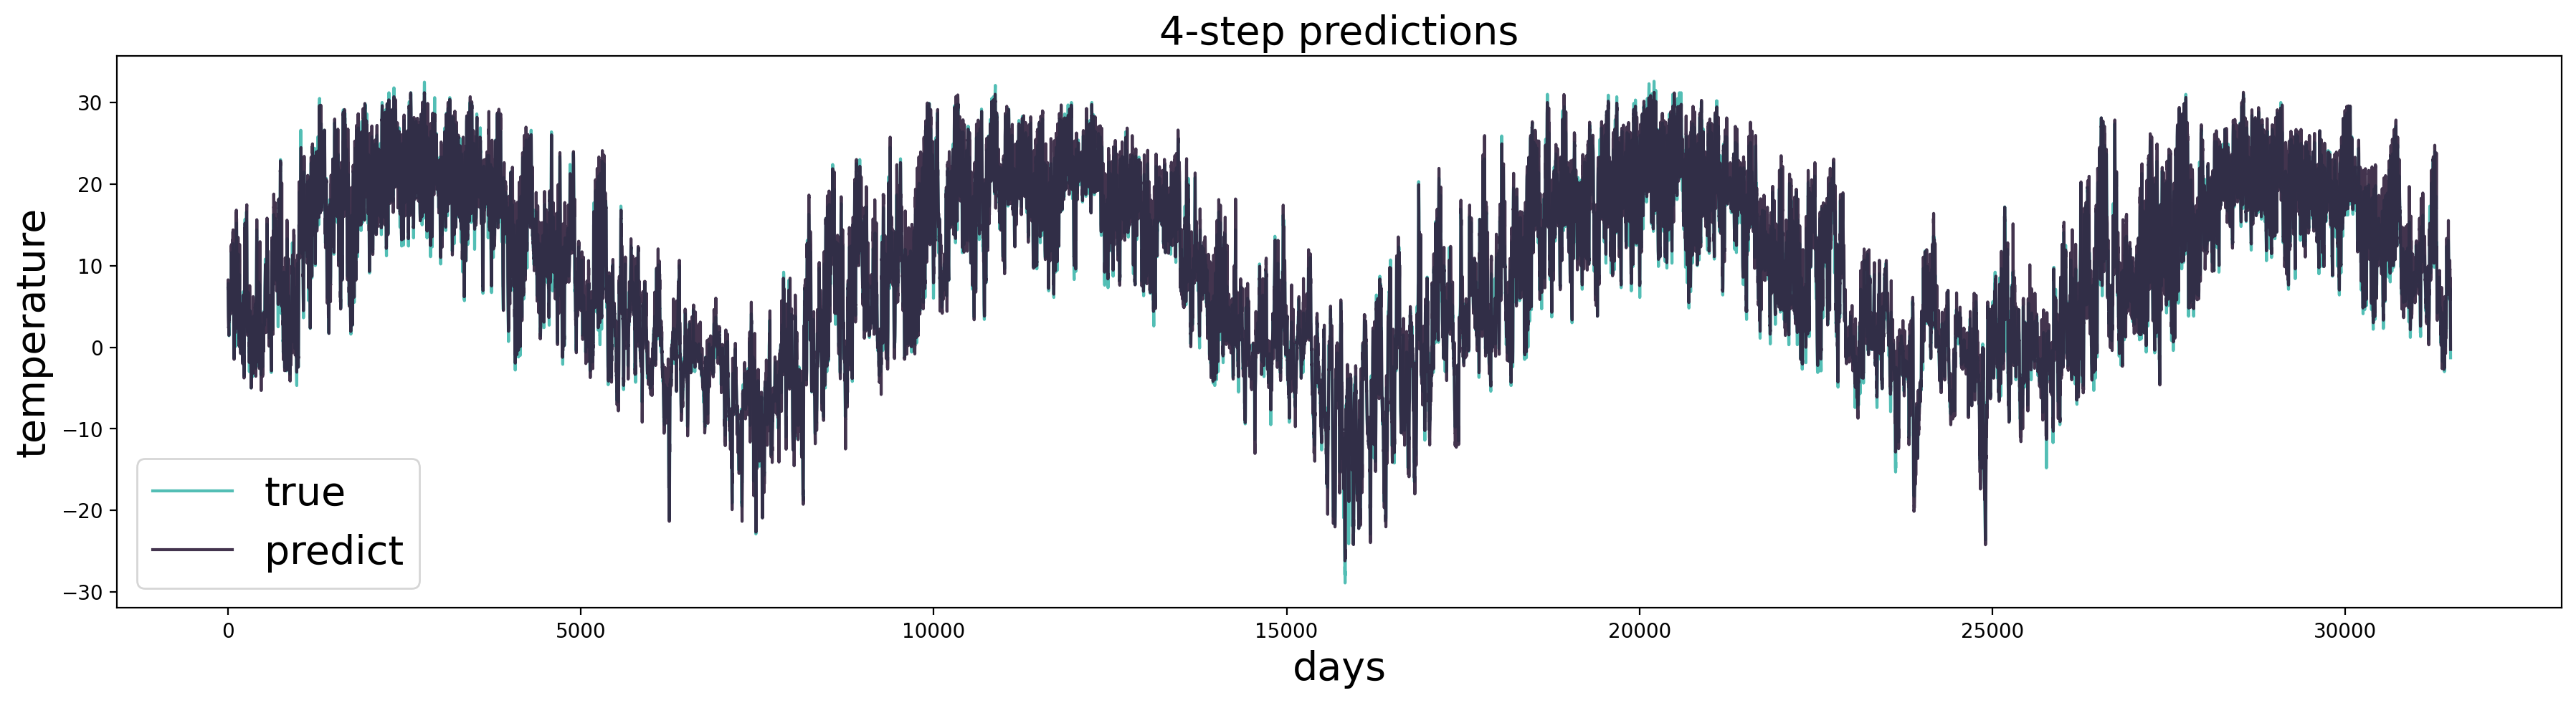

In [20]:
for i in range(4):
    plot_forecast(actual['LSTM-FC_16-4'][1][:,i], predictions['LSTM-FC_16-4'][1][:,i], title = str(i+1) + '-step predictions')

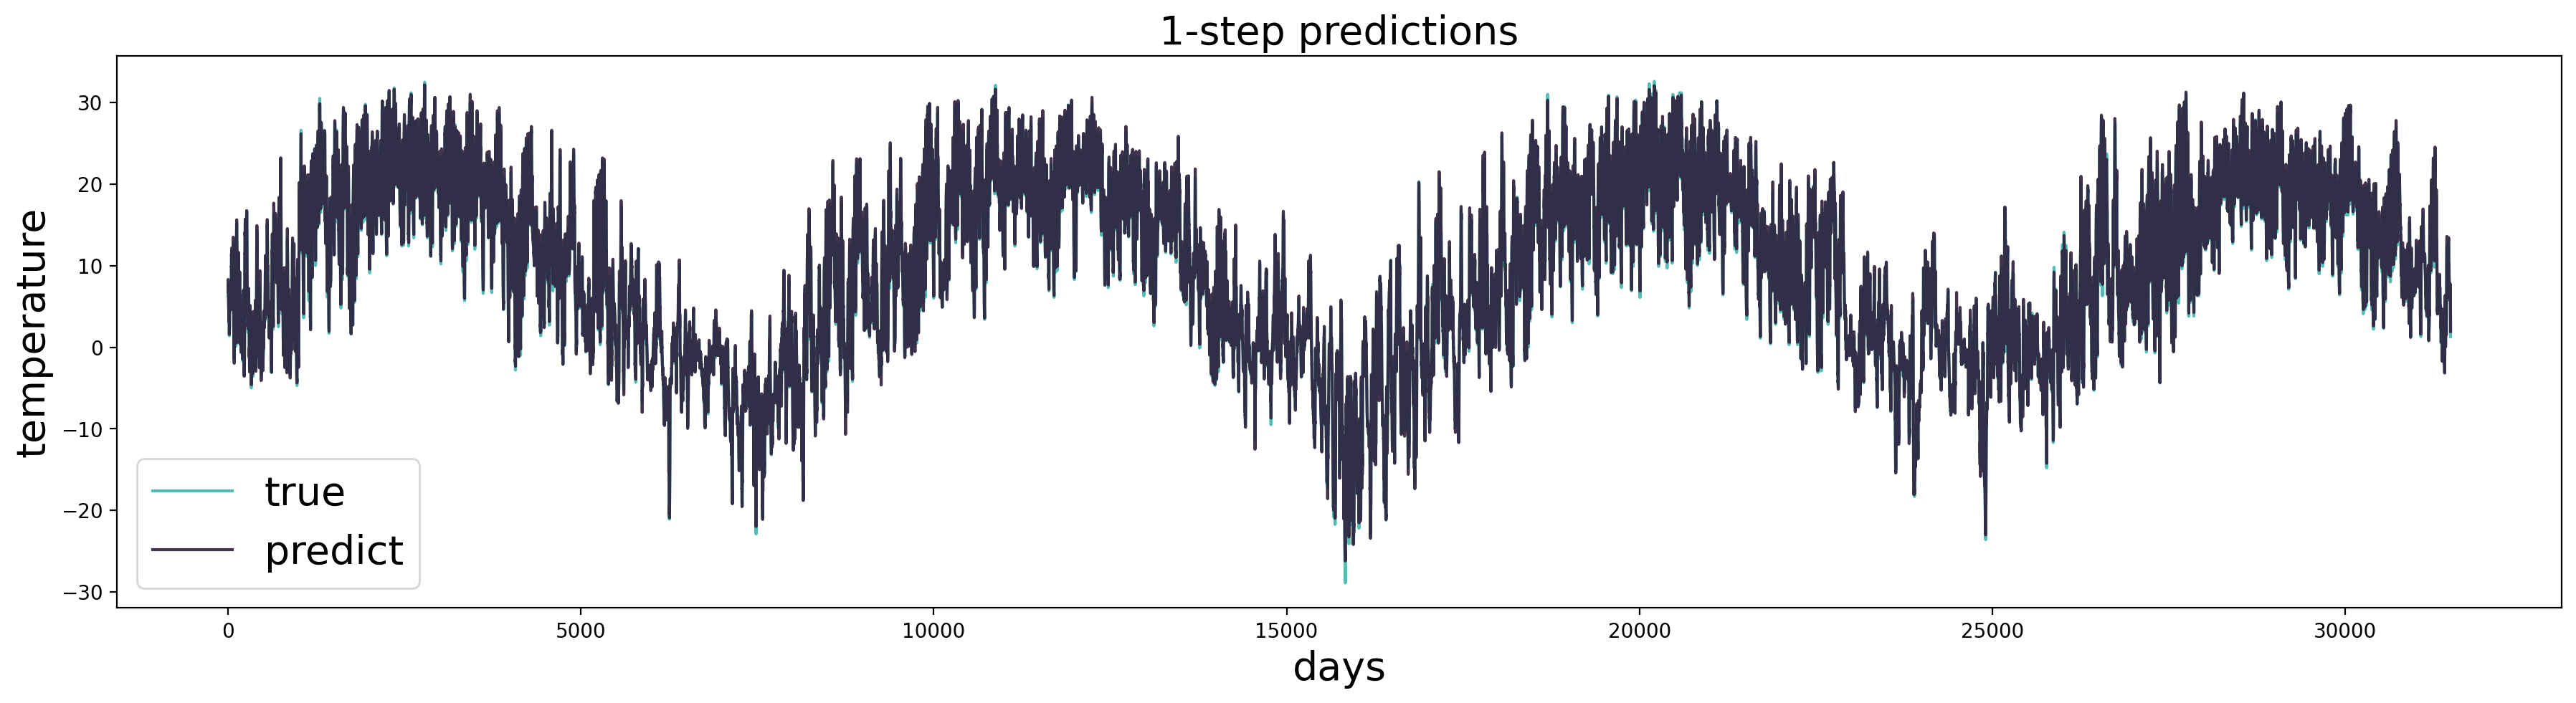

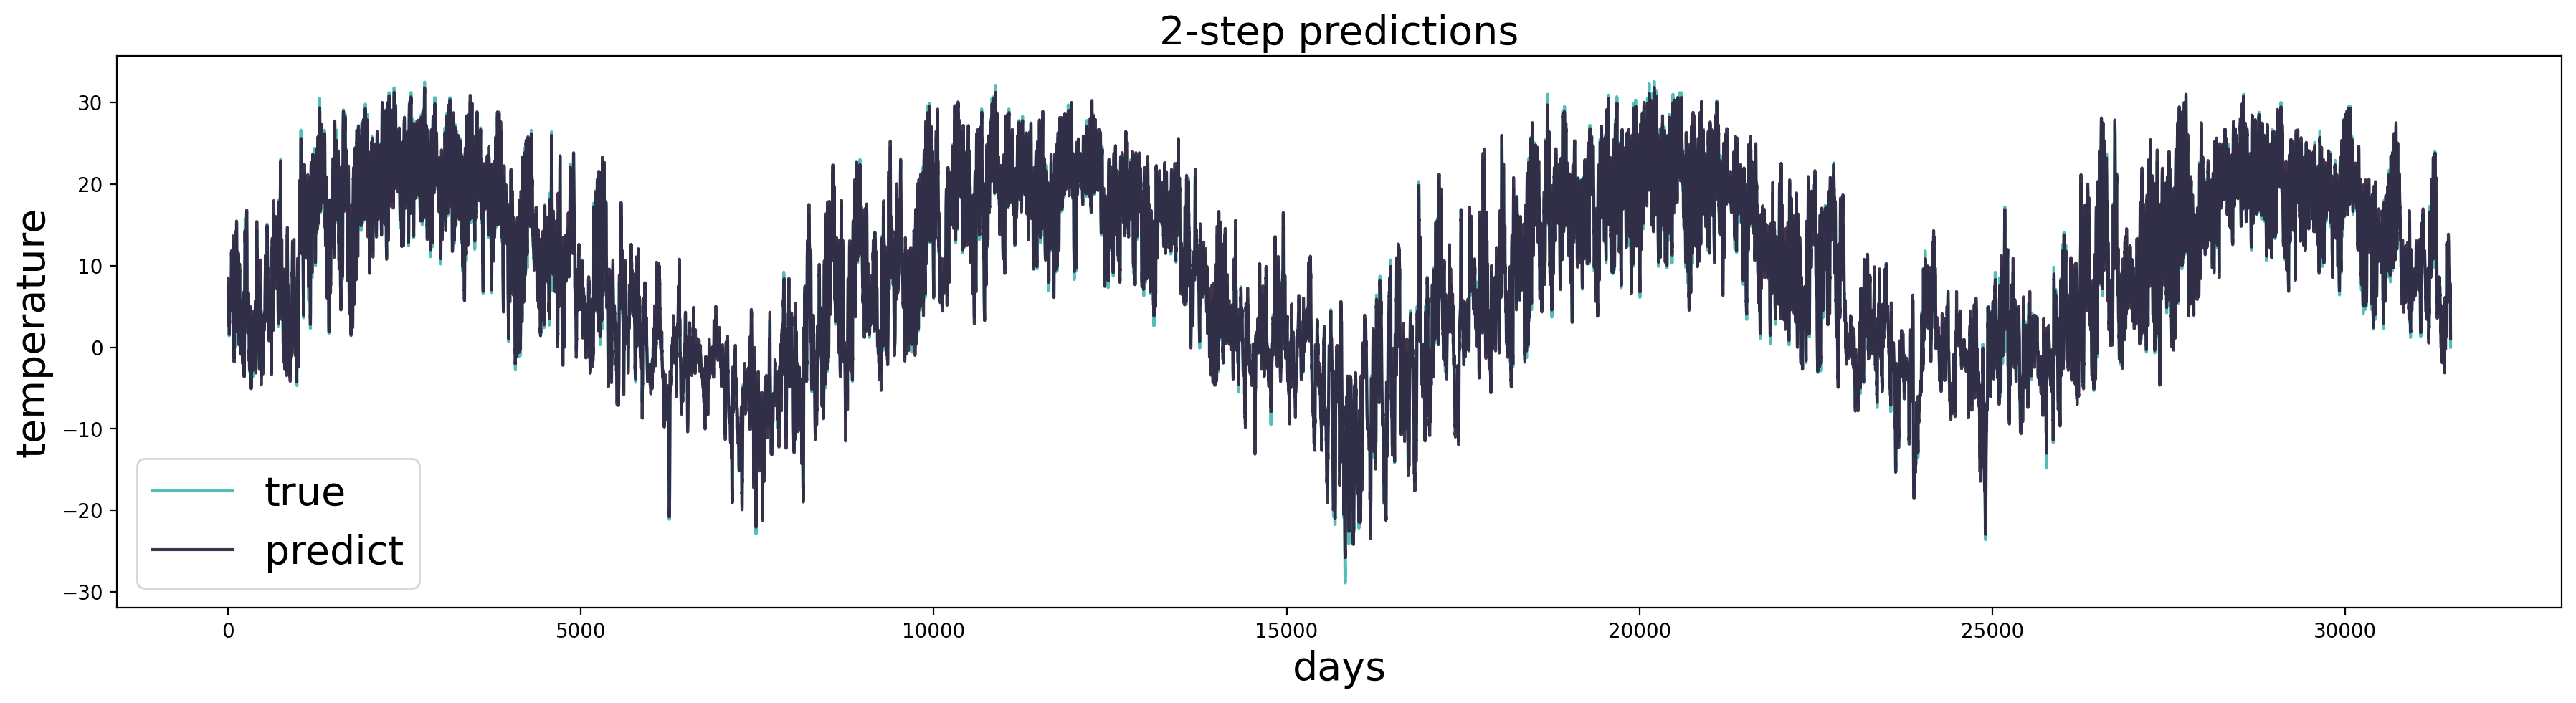

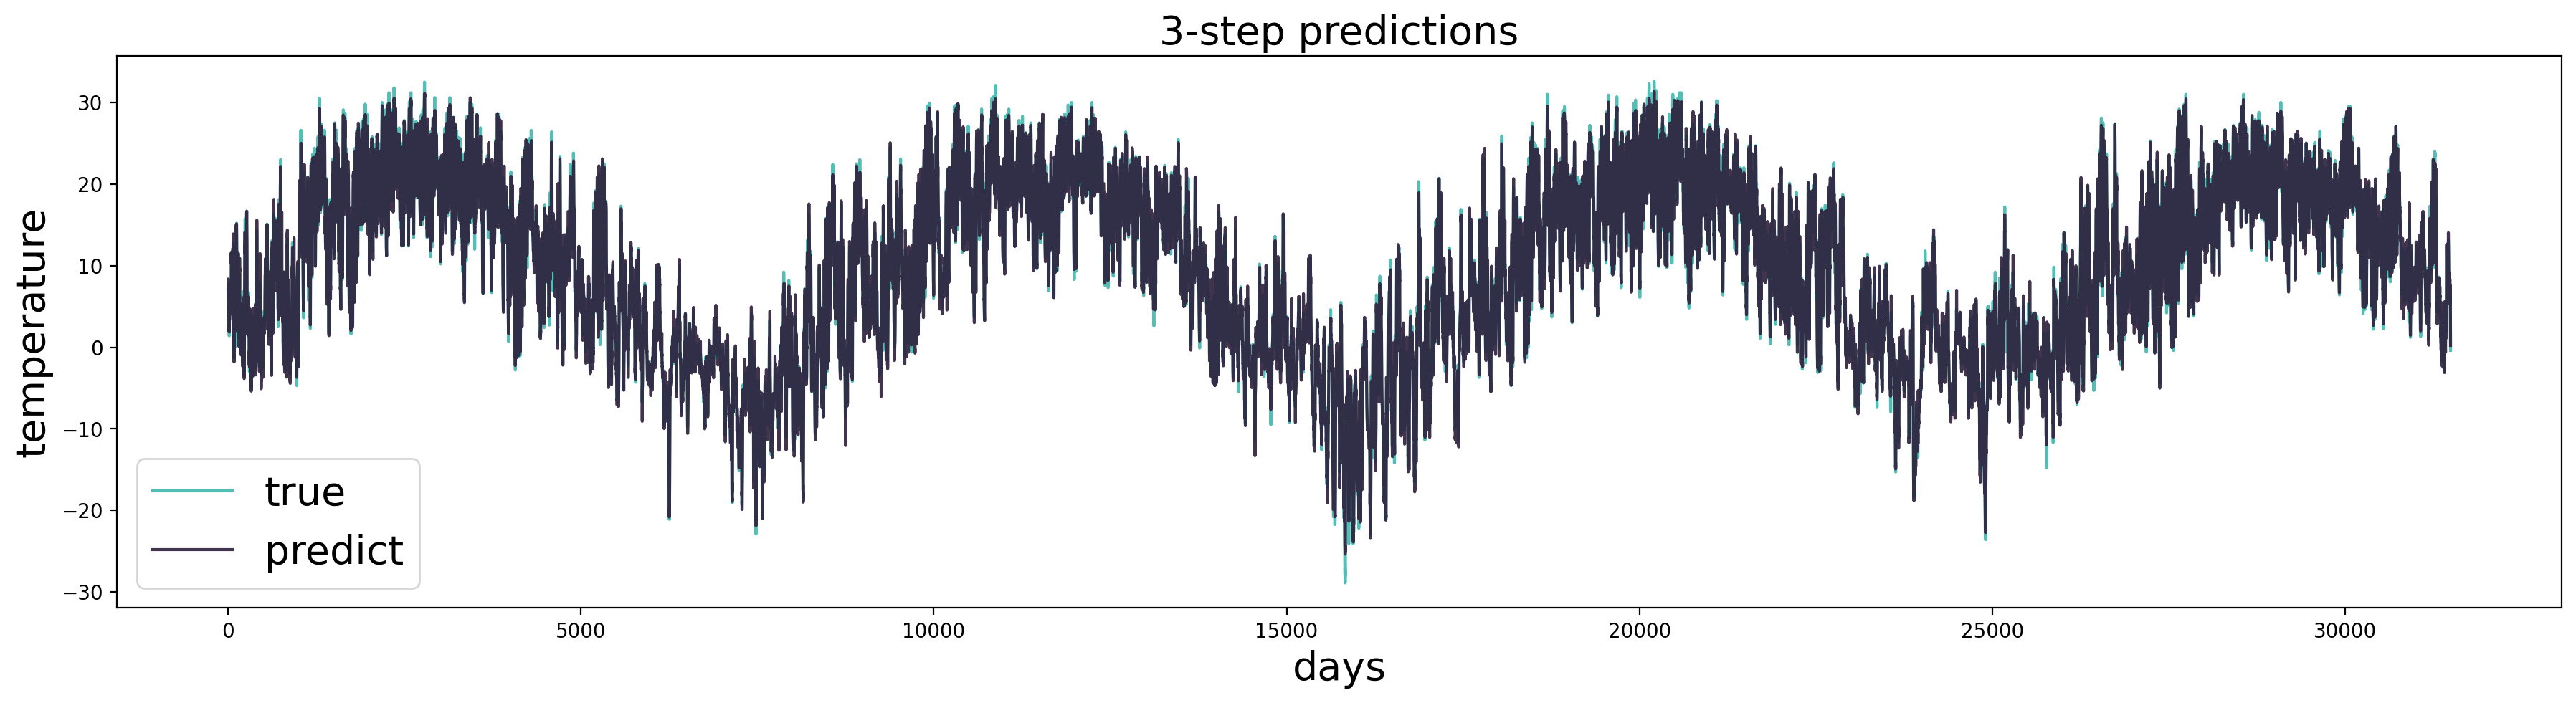

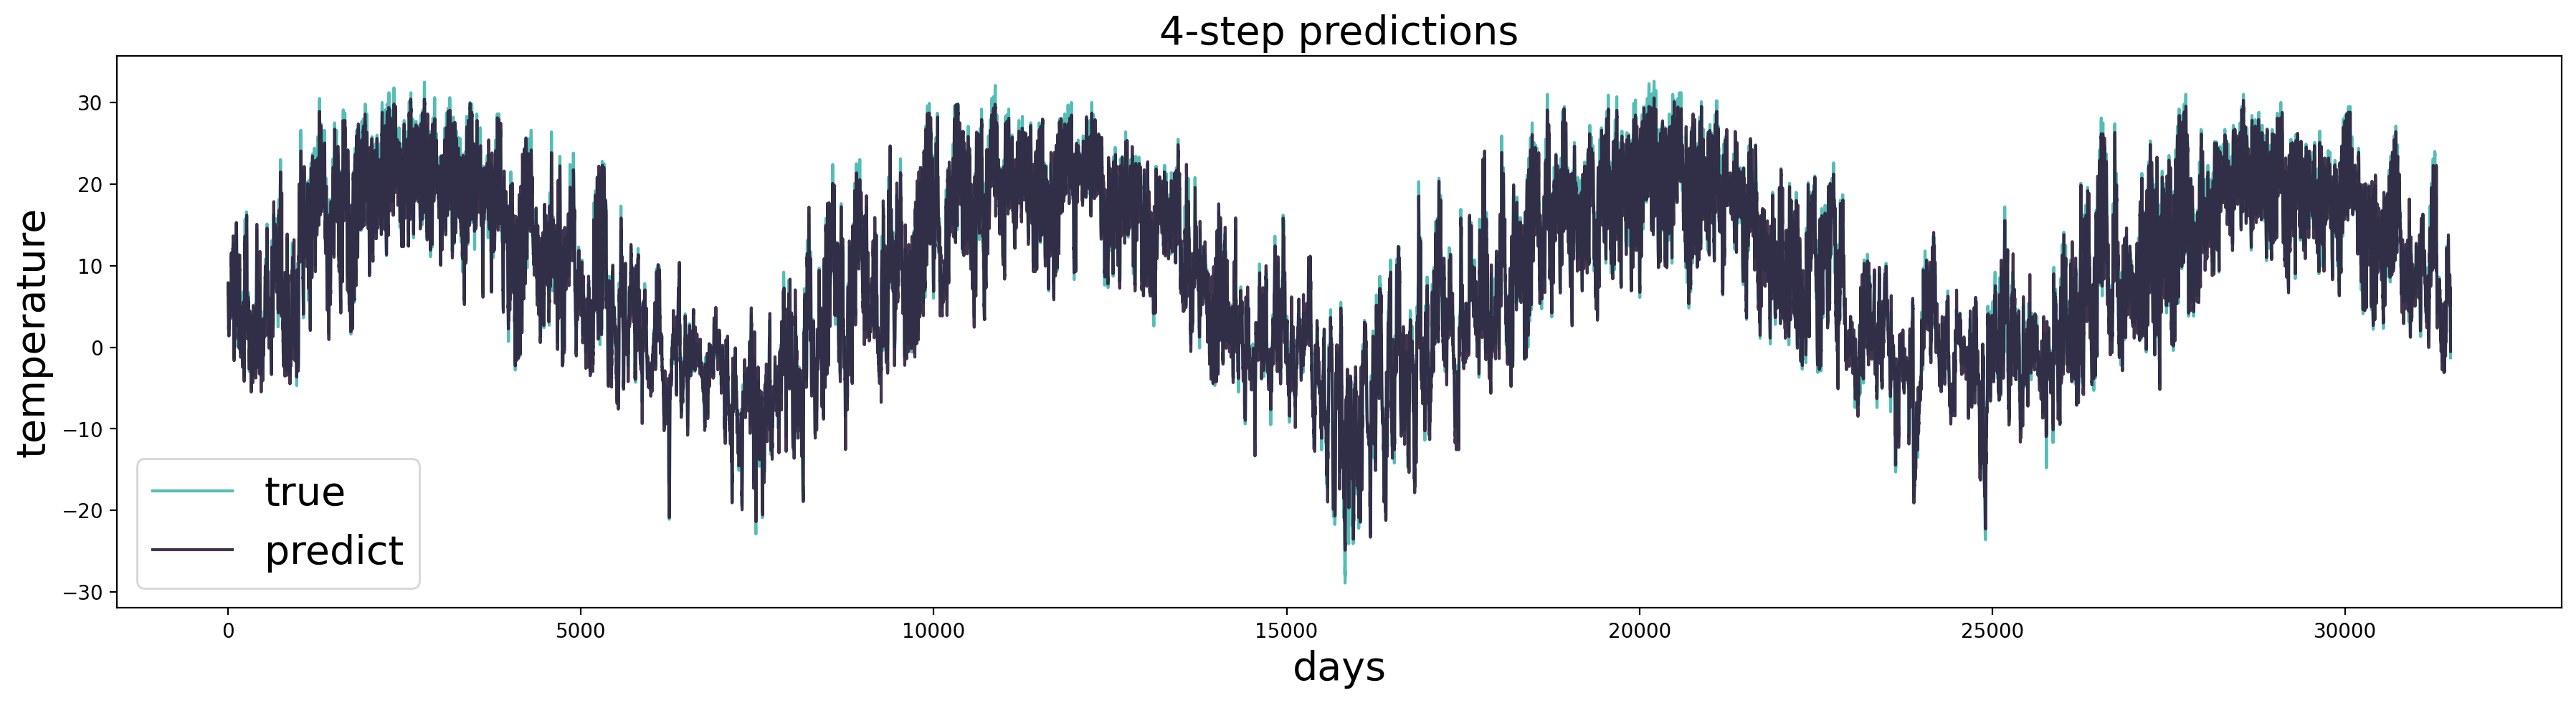

In [21]:
for i in range(4):
    plot_forecast(actual['BiLSTM_16-4'][1][:,i], predictions['BiLSTM_16-4'][1][:,i], title = str(i+1) + '-step predictions')